# Representation of the Pareto front

Problem statement: Given a multi-objective optimization problem
\begin{align}
\min_{x \in \mathcal{X}} ~ &f_{m}(x) \quad m = 1,..,M
\end{align}
where $x$ is the design variable and $\mathcal{X} \subseteq \mathbb{R}^N$ is the feasible set, we are interested in the set $\mathcal{X}^*$ of Pareto efficient solutions.
For continuous problems this set is generally infinite, so we need to find a representative finite subset $\mathcal{X}_R \subset \mathcal{X}^*, \mathcal{Y}_R = f(\mathcal{X}_R)$ in order to use it for visualization and decision making.

Using a suitable weight-based [scalarization method](topics/multiobjective_scalarization.ipynb) each weight vector $w$ maps to a point on the Pareto front. We can thus construct a grid of weights to obtain a grid of points on the Pareto front that can be used to approximate the Pareto optimal objective value for the given weight within error $\epsilon$ via interpolation. The number of grid points is $O((1/\epsilon)^M)$ which for large $M$ becomes compute-expensive to obtain and handle.
[Sandwiching](#Sandwiching) and [hyperboxing](#Hyperboxing) are iterative methods for finding a smaller representation while maintaining the approximation error $\epsilon$.

### References
* [Klamroth+ (2003) Unbiased approximation in multicriteria optimization](https://link.springer.com/article/10.1007/s001860200217)
* [Küfer+ (2009) Multicriteria Optimization in IMRT Planning, in Handbook of Optimization in Medicine](https://link.springer.com/book/10.1007/b100322)
* [Bortz+ (2014) Multicriteria optimization in chemical process design and decision support by navigating on Pareto sets](https://www.sciencedirect.com/science/article/abs/pii/S0098135413002962)
* [Dächert+ (2020) An improved hyperboxing algorithm for calculating a Pareto front representation](https://arxiv.org/abs/2003.14249)

### Toy Pareto fronts 
In the following we want to consider convex and non-convex Pareto fronts. Instead of chosing a multiobjective function $f(x)$ with the desired Pareto front and setting up a function that solves a scalarized minimization problem, e.g. the weighted sum $\min_x \sum w_m f_m(x)$ for given weights, we directly model the Pareto front as function of the weights. 
  
Each function takes a weight vector on the unit simplex and returns the minimum of a multiobjective optimization problem corresponding to the weighted sum scalarization. All objectives are unit-normalized, $f\in [0, 1]^M$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.spatial
import pyreto

In [2]:
def front_flat(w):
    return 1 - w
    
def front_convex(w):
    return (1 - w)**1.5

def front_nonconvex(w):
    return (1 - w)**0.75

def scatterplot(Y, x0=0, x1=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
    ax.plot([0, 1], [1, 0], 'k--', alpha=0.4)  # line connecting the individual minima
    ax.scatter(Y[:, x0], Y[:, x1])  # scatter plot x0 vs x1
    ax.scatter(0, 0, marker='+', color='r')  # ideal point
    ax.set(xlabel=f"$x_{x0}$", ylabel=f"$x_{x1}$")

##### Example in 2D:

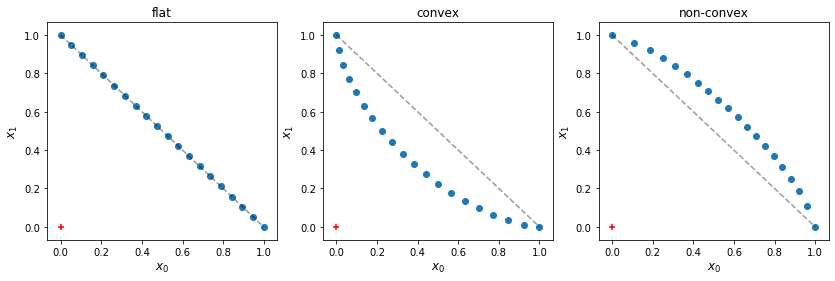

In [3]:
W = pyreto.util.simplex_grid(dimension=2, levels=20)
Y1 = front_flat(W)
Y2 = front_convex(W)
Y3 = front_nonconvex(W)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
scatterplot(Y1, ax=ax1)
scatterplot(Y2, ax=ax2)
scatterplot(Y3, ax=ax3)
ax1.set_title("flat")
ax2.set_title("convex")
ax3.set_title("non-convex");

### Linear Interpolation
We can use a triangulation for a linear interpolation in M dimensions.

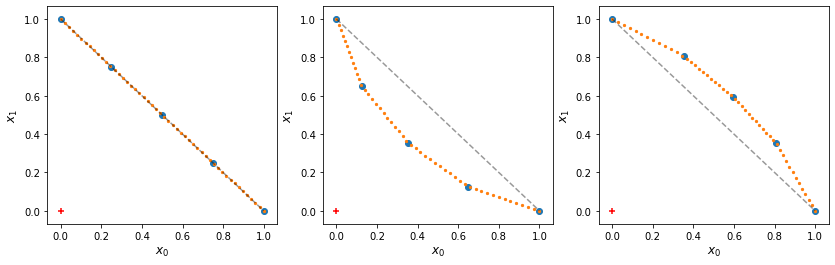

In [4]:
W = pyreto.util.simplex_grid(dimension=2, levels=5)
Y1 = front_flat(W)
Y2 = front_convex(W)
Y3 = front_nonconvex(W)
Wi = pyreto.util.simplex_grid(dimension=2, levels=50)

# Qhull complains as the weight grid is n-1 dimensional (sum wi = 1), so we leave out one coordinate
# Alternatively we could create a triangulation with the "QJ" option and pass that to scipy.interpolate.LinearNDInterpolation
Y1i = scipy.interpolate.griddata(W[:, 1:], Y1, Wi[:, 1:]).squeeze()
Y2i = scipy.interpolate.griddata(W[:, 1:], Y2, Wi[:, 1:]).squeeze()
Y3i = scipy.interpolate.griddata(W[:, 1:], Y3, Wi[:, 1:]).squeeze()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
scatterplot(Y1, ax=ax1)
scatterplot(Y2, ax=ax2)
scatterplot(Y3, ax=ax3)
ax1.scatter(*Y1i.T, s=5)
ax2.scatter(*Y2i.T, s=5)
ax3.scatter(*Y3i.T, s=5);

Unfortunately, the complexity for the underlying Delauny triangulation becomes impractical for $M > 8$.

In [9]:
W = pyreto.util.simplex_grid(dimension=8, levels=5)
Wi = pyreto.util.simplex_sample(dimension=8, samples=10)
Y = front_convex(W)
Yi = scipy.interpolate.griddata(W[:, 1:], Y, Wi[:, 1:]).squeeze()

Instead, we could implement a bespoke interpolation which does not require a prior triangulation by making use of the regular simplex grid layout. 

### Sandwiching

Sandwiching is an iterative method for convex Pareto fronts and is used together with weighted sum scalarizations.
* Inner approximation: linear interpolation of the obtained Pareto points.
* Outer approximation: half space defined by all tangent planes at the obtained Pareto points. For the weighted sum scalarization the weight vector used to find a Pareto point is the normal of the tangent plane at that point.  

For each facet, the distance between the outer and inner approximation with respect to the nadir point is used calculated and a new point is added if the ratio of the two is larger than $1 + \epsilon$. For adding a new point, again a weighted sum scalarization with the weight vector corresponding to the direction to the nadir point is used.

TODO: clarify how the distance is calculated

<img src="../media/sandwiching.png" height="300" />
figure from Bortz+ 2014

### Hyperboxing

Hyperboxing is an iterative method for arbitrary Pareto fronts.
* Inner approximation: space dominated by $\mathcal{Y}_R$
* Outer approximation: space that dominates $\mathcal{Y}_R$

The size of the hyperboxes formed by neighboring points is used as infill criterion. New points are then added through a Pascoletti-Serafini scalarization along the diagonal of the hyperbox.

As size of the hyperbox Bortz+ 2014 use the length of the line connecting the nadir and ther upper corner (inner approximation), and its second intersection (outer approximation). Instead, Dächert+ 2020 use the minimum edge length as criterion. 

<img src="../media/hyperboxing.png" height="300" />
figure from Bortz+ 2014